# Convolutional Networks using MXNet


In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);


Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
  
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
        
    }}                                               
                                                     
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);


var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)





<IPython.core.display.Javascript object>

In [2]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from cs231n.classifiers.cnn import *
# from cs231n.data_utils import get_CIFAR10_data
# from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
# from cs231n.layers import *
# from cs231n.fast_layers import *
# from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

# x = np.random.randn(2, 3, 16, 16)
# w = np.random.randn(3, 3, 3, 3)
# b = np.random.randn(3,)
# dout = np.random.randn(2, 3, 8, 8)
# conv_param = {'stride': 1, 'pad': 1}
# pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

# out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
# dx, dw, db = conv_relu_pool_backward(dout, cache)

# dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
# dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
# db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# print ('Testing conv_relu_pool')
# print ('dx error: ', rel_error(dx_num, dx))
# print ('dw error: ', rel_error(dw_num, dw))
# print ('db error: ', rel_error(db_num, db))

In [ ]:
# from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

# x = np.random.randn(2, 3, 8, 8)
# w = np.random.randn(3, 3, 3, 3)
# b = np.random.randn(3,)
# dout = np.random.randn(2, 3, 8, 8)
# conv_param = {'stride': 1, 'pad': 1}

# out, cache = conv_relu_forward(x, w, b, conv_param)
# dx, dw, db = conv_relu_backward(dout, cache)

# dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
# dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
# db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# print ('Testing conv_relu:')
# print ('dx error: ', rel_error(dx_num, dx))
# print ('dw error: ', rel_error(dw_num, dw))
# print ('db error: ', rel_error(db_num, db))

## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [7]:
import _pickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename, astype='float'):
  """ load single batch of cifar """
  print(filename)
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(astype)
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT, n=1, astype='float'):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1, n+1):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f, astype=astype)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  # Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'), astype=astype)
  return Xtr, Ytr, # Xte, Yte


def get_CIFAR10_data(num_training=17000, num_validation=1000,
                     num_test=2000, astype='float'):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    import math
    cifar10_dir = '../CS231n_assignment2/cs231n/datasets'
    n = math.ceil((num_training + num_validation + num_test) / 10000)
    X_train, y_train = load_CIFAR10(cifar10_dir, n=int(n), astype=astype)

    # Subsample the data
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    mask = list(mask)
    X_test = X_train[mask]
    y_test = y_train[mask]

    mask = range(num_training, num_training + num_validation)
    mask = list(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]

    mask = range(num_training)
    mask = list(mask)
    X_train = X_train[mask]
    y_train = y_train[mask]

    print('X_train', X_train.shape)
    print('X_val', X_val.shape)
    print('X_test', X_test.shape)
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }


# data = get_CIFAR10_data(num_training=17000, num_validation=1000,
#                         num_test=2000, astype='float')
data = get_CIFAR10_data(num_training=19000, num_validation=1000,
                        num_test=0, astype=np.float32)

for k, v in data.items():
  print ('%s: ' % k, v.shape)

../CS231n_assignment2/cs231n/datasets\data_batch_1
../CS231n_assignment2/cs231n/datasets\data_batch_2
X_train (19000, 32, 32, 3)
X_val (1000, 32, 32, 3)
X_test (0, 32, 32, 3)
X_train:  (19000, 3, 32, 32)
y_train:  (19000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (0, 3, 32, 32)
y_test:  (0,)


## Create MXNet Model

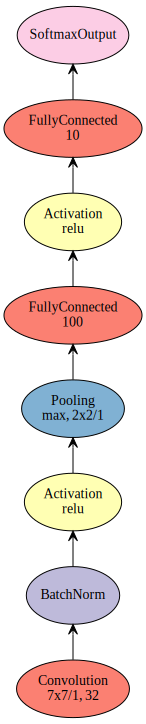

In [8]:
# using mxnet
import mxnet as mx
# import logging
import numpy as np


def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), act_type="relu"):
    # there is an optional parameter ```wrokshpace``` may influece convolution performance
    # default, the workspace is set to 256(MB)
    # you may set larger value, but convolution layer only requires its needed but not exactly
    # MXNet will handle reuse of workspace without parallelism conflict
    conv = mx.symbol.Convolution(data=data, workspace=256,
                                 num_filter=num_filter, kernel=kernel, stride=stride, pad=pad)
    bn = mx.symbol.BatchNorm(data=conv)
    act = mx.symbol.Activation(data = bn, act_type=act_type)
    return act
  

  
# conv - relu - 2x2 max pool - affine - relu - affine - softmax
#     N, C, H, W = X.shape
#     crp_out, crp_cache = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
#     N, F, Hout, Wout = crp_out.shape
#     crp_out = crp_out.reshape((N, -1))  # N, F, Hout, Wout -> N, F*Hout*Wout
#     hidden_out, hidden_cache = affine_relu_forward(crp_out, W2, b2)
#     scores, scores_cache = affine_forward(hidden_out, W3, b3)

# def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
#              hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
  
#     conv_param = {'stride': 1, 'pad': int((filter_size - 1) / 2)}
#     pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}
imagedata = mx.symbol.Variable(name="data")
conv_bn_relu = ConvFactory(data=imagedata, kernel=(7,7), pad=(3,3), num_filter=32, act_type="relu")
pool = mx.symbol.Pooling(data=conv_bn_relu, pool_type="max", kernel=(2,2), name="global_max")
affine = mx.symbol.FullyConnected(data=pool, num_hidden=100)
relu = mx.symbol.Activation(data=affine, act_type="relu")
affine2 = mx.symbol.FullyConnected(data=relu, num_hidden=10)
softmax = mx.symbol.SoftmaxOutput(name='softmax', data=affine2)

mx.viz.plot_network(symbol=softmax,
                    node_attrs={'shape':'oval','fixedsize':'false'}
                   )


## Load Data

In [26]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# model = ThreeLayerConvNet(weight_scale=1e-2)

# solver = Solver(model, small_data,
#                 num_epochs=10, batch_size=50,
#                 update_rule='adam',
#                 optim_config={
#                   'learning_rate': 1e-3,
#                 },
#                 verbose=True, print_every=1)
# solver.train()



# We will make model with current current symbol
# For demo purpose, this model only train 1 epoch
# We will use the first GPU to do training
model = mx.model.FeedForward(ctx=mx.cpu(),
                             symbol=softmax,
                             num_epoch=3,
                             learning_rate=0.0001,
                             momentum=0.9,
                             wd=0.00001
                            )

## Train MXNet

In [27]:

import sys

batch_size = 50
# class mxnet.io.NDArrayIter(data, label=None, batch_size=1, shuffle=False, last_batch_handle='pad', 
#                            label_name='softmax_label')
# NDArrayIter object in mxnet. Taking NDArray or numpy array to get dataiter.

# data (NDArray or numpy.ndarray, a list of them, or a dict of string to them.) – NDArrayIter supports single or multiple data and label.
# label (NDArray or numpy.ndarray, a list of them, or a dict of them.) – Same as data, but is not fed to the model during testing.
# batch_size (int) – Batch Size
# shuffle (bool) – Whether to shuffle the data
# last_batch_handle ('pad', 'discard' or 'roll_over') – How to handle the last batch

train_dataiter = mx.io.NDArrayIter(data=small_data['X_train'], 
                                   label=small_data['y_train'], 
                                   batch_size=batch_size, 
                                   shuffle=True, 
                                   last_batch_handle='pad', 
#                                    label_name='softmax_label_train'
                                  )


val_dataiter = mx.io.NDArrayIter(data=small_data['X_val'], 
                                 label=small_data['y_val'], 
                                 batch_size=batch_size,
                                 shuffle=True,
                                 last_batch_handle='pad', 
#                                  label_name='softmax_label_val'
                                )


# epoch_end_callback (function or list of function)
# – Each callback will be called with the current epoch, symbol, arg_params and aux_params.

callback = lambda epoch, symbol, arg_params, aux_params: print(epoch, symbol)
model.fit(X=train_dataiter,
          eval_data=val_dataiter,
          eval_metric="accuracy",
          epoch_end_callback=callback
         )

0 <mxnet.symbol.Symbol object at 0x00000202CB331A58>
1 <mxnet.symbol.Symbol object at 0x00000202CB331A58>
2 <mxnet.symbol.Symbol object at 0x00000202CB331A58>


## and... results?

In [29]:
# We can use the model to do prediction

# prob = model.predict(test_dataiter)
prob = model.predict(val_dataiter)
print('Finish predict...')
# Check the accuracy from prediction
val_dataiter.reset()

y = small_data['y_val']
# get prediction label from 
py = np.argmax(prob, axis=1)
print(py)
print('='*10)
print(y)
acc1 = float(np.sum(py == y)) / len(y)
print('final accuracy = ', acc1)

Finish predict...
[5 0 1 6 6 6 6 1 1 6 1 6 0 6 6 6 9 0 1 5 1 6 1 1 6 1 1 0 0 2 6 1 1 1 2 1 2
 1 1 6 6 6 6 1 6 6 1 1 2 5 1 6 5 0 1 6 2 2 2 6 6 6 6 6 1 6 6 6 0 0 1 0 6 6
 1 1 1 6 1 1 6 1 1 0 6 1 0 6 6 7 0 1 0 6 1 1 6 6 1 6 2 6 0 2 1 1 6 2 1 7 6
 1 1 0 6 2 1 1 1 1 1 1 6 6 1 1 1 2 1 1 6 2 1 2 1 2 1 0 0 1 6 6 7 2 1 1 1 2
 6 6 1 2 6 6 1 1 1 0 6 6 6 6 0 0 1 2 1 1 2 6 6 0 6 6 1 6 6 1 1 6 1 1 6 6 2
 1 6 1 6 2 6 6 1 6 6 6 6 6 1 6 6 0 6 6 6 0 6 1 1 1 6 0 2 1 0 6 1 9 1 6 6 6
 1 9 0 6 6 6 6 6 1 6 6 1 1 0 1 1 1 6 1 6 1 7 1 6 0 6 1 6 2 6 1 0 1 1 0 2 0
 1 2 2 6 0 6 0 1 1 1 1 1 6 1 1 2 6 5 9 6 1 6 0 6 2 1 6 6 1 6 6 1 2 1 1 6 6
 1 6 6 6 6 6 1 1 6 1 1 6 1 1 6 0 6 1 1 1 1 6 2 6 9 1 6 5 6 2 6 7 1 6 6 1 6
 0 1 6 1 1 1 6 0 1 1 2 2 2 1 1 0 1 5 1 6 1 1 6 1 1 0 1 1 6 6 6 1 6 1 1 6 1
 2 1 2 6 6 6 6 6 6 1 6 2 1 1 0 6 6 6 6 1 6 6 1 1 1 9 1 6 6 1 6 5 1 1 1 2 2
 5 1 6 6 6 6 6 0 6 1 6 2 5 6 6 1 6 0 6 6 0 0 1 6 0 6 1 7 1 1 1 1 1 6 2 6 1
 6 6 6 9 6 6 6 7 2 6 2 0 2 6 1 6 6 6 6 1 6 6 2 1 0 6 6 6 2 6 1 1 6 1 6 0 6
 6 5 6 

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# Superb!
# CustomConvNet(object):
#   [conv-relu-pool(2,2)]xN - [affine-relu]xM - affine - [softmax]

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [ ]:
model = ThreeLayerConvNet(num_filters=32, weight_scale=0.001, 
                          hidden_dim=500, reg=0.001)


solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different images and different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print ('Before spatial batch normalization:')
print ('  Shape: ', x.shape)
print ('  Means: ', x.mean(axis=(0, 2, 3)))
print ('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization:')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization (nontrivial gamma, beta):')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print ('After spatial batch normalization (test-time):')
print ('  means: ', a_norm.mean(axis=(0, 2, 3)))
print ('  stds: ', a_norm.std(axis=(0, 2, 3)))

## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [ ]:
N, C, H, W = 2, 3, 4, 5
# N > 2 时 dx_error 会比较好看 why?
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print ('dx error: ', rel_error(dx_num, dx))
print ('dgamma error: ', rel_error(da_num, dgamma))
print ('dbeta error: ', rel_error(db_num, dbeta))

# print('dx_num', dx_num)
# print('dx', dx)

print(np.max(dx_num - dx))
# print(dx_num - dx)


def rel_error_mat(x, y):
  return np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))

print(rel_error_mat(dx_num, dx))

print(dx)

# print('dgamma', da_num, dgamma)
# print('dbeta', db_num, dbeta)

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [ ]:

num_train = 500
middle_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


In [ ]:
%%time

import math
import random
from cs231n.classifiers.cnn import CustomConvNet


class RandomRoll():
  def __init__(self, min, max=None, kind='exp'):
    self.a = min
    self.b = max
    self.kind = kind
  def roll(self):
    if self.b is None and isinstance(self.a, list):
      p = random.choice(self.a)
    elif self.kind == 'exp':
      p = 10 ** random.uniform(math.log10(self.a), math.log10(self.b))
    elif self.kind == 'linear':
      p = random.uniform(a, b)
    return p
  

def clip_small_data(data, num_train=500, num_val=500):
  small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'][:num_val],
    'y_val': data['y_val'][:num_val],
  }
  return small_data

def random_select(a, b=None, kind='exp'):
  if kind == 'exp':
    p = 10 ** random.uniform(math.log10(a), math.log10(b))
  elif kind == 'linear':
    p = random.uniform(a, b)
  return p

def random_search(data,
                  max_search_times=20,
                  report_val_acc=0.2,
                  num_epochs=3,
                  lr_decays=RandomRoll(0.5, 0.99),   # 0.99
                  weight_scales=RandomRoll(0.001, 0.1),  # 5e-2
                  regs=RandomRoll(0.1, 1, 'linear'),  # 0.01
                  learning_rates=RandomRoll(0.001, 0.1),  # 1e-2
                  use_batchnorms=RandomRoll([True, False]),
                  results=[],
                  ):
  

  print('data shape', data['X_train'].shape)
  for i in range(max_search_times):

    model = CustomConvNet(input_dim=(3, 32, 32),
                          filters=(36,24,24),
                          filter_size=3,
                          hidden_dims=(500,300),
                          num_classes=10,
                          weight_scale=weight_scales.roll(),
                          reg=regs.roll(),
                          use_batchnorm=use_batchnorms.roll(),
                          dtype=np.float32)

    if i % 1 == 0:
      print('try params ', i+1, max_search_times)
      
    solver = Solver(model, 
                    data,
                    num_epochs=num_epochs, 
                    batch_size=250,
                    update_rule='adam',
                    lr_decay=lr_decays.roll(),
                    optim_config={
                      'learning_rate': learning_rates.roll(),
                    },
                    verbose=False)
    solver.train()
    val_acc = max(solver.val_acc_history)
#     if val_acc >= stop_val_acc:
#       break
    if val_acc >= report_val_acc:
      results.append(solver.report_hyper_params(verbose=True))
    else:
      results.append(solver.report_hyper_params(verbose=False))

  print('done', max_search_times)
  return results


def print_results(results):
  from pprint import pprint
  ys = [r['last_val_acc'] for r in results]
    
  ax = plt.subplot(5, 1, 1)
  ax.set_xscale('log')
  xs = [r['init_learning_rate'] for r in results]
  plt.plot(xs, ys, 'o')
  plt.xlabel('init_learning_rate')
  plt.ylabel('val acc')
  
  ax = plt.subplot(5, 1, 2)
  xs = [r['lr_decay'] for r in results]
  plt.plot(xs, ys, 'o')
  plt.xlabel('lr_decay')
  plt.ylabel('val acc')
  
  ax = plt.subplot(5, 1, 3)
  ax.set_xscale('log')
  xs = [r['reg'] for r in results]
  plt.plot(xs, ys, 'o')
  plt.xlabel('reg')
  plt.ylabel('val acc')
  
  ax = plt.subplot(5, 1, 4)
  ax.set_xscale('log')
  xs = [r['weight_scale'] for r in results]
  plt.plot(xs, ys, 'o')
  plt.xlabel('weight_scale')
  plt.ylabel('val acc')
  
  ax = plt.subplot(5, 1, 5)
  ax.set_xlim([-1, 2])
  xs = [r['use_batchnorm'] for r in results]
  plt.plot(xs, ys, 'o')
  
  plt.xlabel('use_batchnorm')
  plt.ylabel('val acc')
  

  plt.gcf().set_size_inches(12, 18)
  plt.show()
  
def print_solver(solver):
  
  plt.subplot(2, 1, 1)
  plt.title('Training loss')
  plt.plot(solver.loss_history, 'o')
  plt.xlabel('Iteration')

  plt.subplot(2, 1, 2)
  plt.title('Accuracy')
  plt.plot(solver.train_acc_history, '-o', label='train')
  plt.plot(solver.val_acc_history, '-o', label='val')
  plt.plot([0.5] * len(solver.val_acc_history), 'k--')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.gcf().set_size_inches(15, 12)
  plt.show()

In [ ]:
%%time

### test API

# on full data test 太慢了, 根据有限的 10+ 个测试,
# 选择同样的参数, 作用在 small data 和 full data 上结果差不多
small_data = clip_small_data(data)
best_model = None
results = []
results = random_search(small_data,
                        max_search_times=50,
                        report_val_acc=0.3,
                        num_epochs=1,
                        lr_decays=RandomRoll(0.85, 0.99),  
                        weight_scales=RandomRoll(0.001, 0.1),  
                        regs=RandomRoll(0.001, 3),  
                        learning_rates=RandomRoll(0.0001, 0.01), 
                        use_batchnorms=RandomRoll([True, False]),
                        results=results,
                        )
print(len(results))
print_results(results)


In [ ]:
s = sorted(results, key=lambda x:x['best_val_acc'], reverse=True)
# print(len(results))
# print_results(results)
best_model = s[0]['model']
print(s[0])
print(best_model)

In [ ]:
# small_data = clip_small_data(data)
  
# Train a really good model on CIFAR-10
# model = ThreeLayerConvNet(num_filters=32, weight_scale=0.001, 
#                           hidden_dim=500, reg=0.001)

print('data.X_train.shape', data['X_train'].shape)
solver = Solver(best_model, data,
                num_epochs=5, batch_size=50,
                update_rule='adam',
                lr_decay=0.88,
                optim_config={
                  'learning_rate': 0.001,
                },
                verbose=True, print_every=20)
solver.train()

# X_train 9000 个数据, 最高到57% val acc, 累死我了
# on 19000, 59% val acc
# houhouhou (Epoch 5 / 5) train acc: 0.716000; val_acc: 0.659000


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.